# Load Useful Functions

In [1]:
%run "0_Helper_Function_GLM_VOL_OMR.ipynb"

...

['AS+' 'S1+' 'S2+' 'SCS+' 'LCS+' 'BS+' 'J+' 'HAT+' 'RT+' 'SAT+' 'O+'
 'LLC+' 'SLC+' 'AS-' 'S1-' 'S2-' 'SCS-' 'LCS-' 'BS-' 'J-' 'HAT-' 'RT-'
 'SAT-' 'O-' 'LLC-' 'SLC-']
['AS+' 'S1+' 'S2+' 'BS+' 'J+' 'HAT+' 'RT+' 'SAT+' 'O+' 'LLC+' 'SLC+' 'AS-'
 'S1-' 'S2-' 'BS-' 'J-' 'HAT-' 'RT-' 'SAT-' 'O-' 'LLC-' 'SLC-']



----------------------------------------------------------------------
Ran 3 tests in 5.773s

OK


# Load Classifier

In [2]:
from keras.callbacks import Callback
from keras.models import Sequential
from keras.layers import Dense , Dropout

from keras.utils import to_categorical ,Sequence
from keras import backend as K
from keras.models import model_from_json

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2450148305463804557
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 831979520
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 12547293129088321881
physical_device_desc: "device: 0, name: TITAN Xp, pci bus id: 0000:81:00.0, compute capability: 6.1"
]


In [3]:
json_file=open('NeuralNetworkRobust2ShiftNoCS.json', 'r')
model_json = json_file.read()
model = model_from_json(model_json)
model.load_weights("NeuralNetworkRobust2ShiftNoCS.h5")
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_12 (Reshape)         (None, 10, 285)           0         
_________________________________________________________________
permute_12 (Permute)         (None, 285, 10)           0         
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 256, 100)          30100     
_________________________________________________________________
batch_normalization_45 (Batc (None, 256, 100)          400       
_________________________________________________________________
activation_45 (Activation)   (None, 256, 100)          0         
_________________________________________________________________
max_pooling1d_34 (MaxPooling (None, 128, 100)          0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 109, 120)          240120    
__________

# Define Tail Bout Detection Function

In [1]:
from scipy.ndimage.filters import maximum_filter1d 
def max_filter1d_valid(a, W):
    hW = (W-1)//2 # Half window size
    return maximum_filter1d(a,size=W,mode='reflect')#[hW:-hW]

In [2]:
def detect_tail_bouts(tail_angle,NumSegments=9,BCFilt=10,MinFiltSize=20,MaxFiltSize=400,BoutThresh=0.1,MinLength=40,MinAmpl=0.2,TClassif=285):

    # Define Cumul Sum and Find Tracking Nan:
    error_flag=np.where(np.min(tail_angle,1)<-50)[0]
    tail_angle[tail_angle==-100]=0
    cumul_tail_angle=np.cumsum(tail_angle,1)
    num_errors=error_flag.shape[0]

    # For the bout detection we smooth the tail curvature to eliminate kinks due to tracking noise
    notrack=np.where(np.sum(cumul_tail_angle,1)==0)[0]
    smooth_cumul_tail_angle=np.copy(cumul_tail_angle)
    for n in range(1,cumul_tail_angle.shape[1]-1):
        smooth_cumul_tail_angle[:,n]=np.mean(cumul_tail_angle[:,n-1:n+2],1)

    for n in range(cumul_tail_angle.shape[1]):
        tmp=cumul_tail_angle[:,n]
        tmp=signal.savgol_filter(tmp, 11, 2, deriv=0, delta=1.0, axis=-1, mode='interp', cval=0.0)
        smooth_cumul_tail_angle[:,n]=tmp
    
    # Compute difference in segment angles, because we want to detect tail movement
    tmp=np.diff(smooth_cumul_tail_angle,axis=0)
    z=np.zeros((1,tmp.shape[1]))
    fixed_segments_angles=np.vstack((z,tmp))
    fixed_segments_angles[notrack,:]=0
    
    # Interpolate on NoTrack
    if notrack.shape[0]>0:
        if notrack[-1]==tail_angle.shape[0]-1:
            fixed_segments_angles[notrack[:-1]+1,:]=0
        else:
            fixed_segments_angles[notrack+1,:]=0
    real_segment_angles = fixed_segments_angles[:,0:NumSegments];
    
    # Smooth the tail movement
    filtered_segment_angles=np.zeros_like(real_segment_angles)
    for i in range(real_segment_angles.shape[1]):
        filtered_segment_angles[:,i]= signal.convolve(
            real_segment_angles[:,i],
            1/BCFilt*signal.boxcar(M=BCFilt,sym=False),
            mode='same')

    # Sum the angle differences down the length of the tail to give prominence to regions of continuous curvature in one direction
    cumul_filtered_segment_angles=np.cumsum(filtered_segment_angles,1)

    # Sum the absolute value of this accumulated curvature so bends in both directions are considered
    super_cumul_filtered_segment_angles = np.cumsum(np.abs(cumul_filtered_segment_angles),1)
    tail_curv_measure= signal.convolve(
            super_cumul_filtered_segment_angles[:,-1],
            1/BCFilt*signal.boxcar(M=BCFilt,sym=False),
            mode='same')

    # max filter flattens out beat variations (timescale needs to be adjusted according to be well below the interbout length)
    max_filt=max_filter1d_valid(tail_curv_measure,MinFiltSize)
    # min filter removes baseline fluctuations (needs to be well above the bout length)
    min_filt=-max_filter1d_valid(-tail_curv_measure,MaxFiltSize)
    smoother_tail_curve_measure=max_filt-min_filt
    
    # Find when tail is active
    all_bout=smoother_tail_curve_measure>BoutThresh
    all_bout_f=all_bout.astype(float) 

    tmp=np.diff(all_bout_f,axis=0)
    tmp=np.hstack((0,tmp))
    tmp=np.vstack((tmp,np.zeros_like(tmp)))
    all_bout_start=np.max(tmp,0)

    tmp=-1*np.diff(all_bout_f,axis=0)
    tmp=np.hstack((0,tmp))
    tmp=np.vstack((tmp,np.zeros_like(tmp)))
    all_bout_end=np.max(tmp,0)
    
    # Only use bouts with beginning and end within recording and use end as TClassif 285 ms:
    all_bout_start_ind=np.where(all_bout_start)[0]
    all_bout_end_ind=np.where(all_bout_end)[0]
    if all_bout_start_ind[0]>all_bout_end_ind[0]:
        all_bout_end_ind=all_bout_end_ind[1:]

    if len(all_bout_start_ind)>len(all_bout_end_ind):
        all_bout_start_ind=all_bout_start_ind[0:-1]
    
    # Make sure it is compatible with the reshaping done during concatenate_bouts_for_classification
    not_too_late=(all_bout_start_ind+TClassif<tail_angle.shape[0])
    all_bout_start_ind=all_bout_start_ind[not_too_late]
    all_bout_end_ind=all_bout_end_ind[not_too_late]
    not_too_early=(all_bout_start_ind-10>0)
    all_bout_start_ind=all_bout_start_ind[not_too_early]
    all_bout_end_ind=all_bout_end_ind[not_too_early]
        
    bout_duration=np.zeros(all_bout_start_ind.shape)
    bout_ampl=np.zeros(all_bout_start_ind.shape)
    for i in range(len(all_bout_start_ind)):
        bout_duration[i]=all_bout_end_ind[i]-all_bout_start_ind[i]
        tmp=smooth_cumul_tail_angle[all_bout_start_ind[i]:all_bout_end_ind[i],7]-smooth_cumul_tail_angle[all_bout_start_ind[i],7]
        bout_ampl[i]=np.max(np.abs(tmp))
    
    bad_bouts=np.logical_or(bout_duration<MinLength,bout_ampl<MinAmpl)

    good_bout_start_ind=all_bout_start_ind[~bad_bouts]
    good_bout_end_ind=all_bout_end_ind[~bad_bouts]
    bad_bout_start_ind=all_bout_start_ind[bad_bouts]
    bad_bout_end_ind=all_bout_end_ind[bad_bouts]
    
    
    bouts = {'tail_angle':tail_angle,'cumul_tail_angle': cumul_tail_angle,'smoother_tail_curve_measure':smoother_tail_curve_measure, 'smooth_cumul_tail_angle': smooth_cumul_tail_angle,
           'cumul_filtered_segment_angles': cumul_filtered_segment_angles,'super_cumul_filtered_segment_angles': super_cumul_filtered_segment_angles,
           'all_bout': all_bout,'all_bout_start':all_bout_start,'all_bout_end':all_bout_end,
            'all_bout_start_ind': all_bout_start_ind,'all_bout_end_ind': all_bout_end_ind,
           'good_bout_start_ind': good_bout_start_ind,'good_bout_end_ind': good_bout_end_ind,
           'bad_bout_start_ind': bad_bout_start_ind,'bad_bout_end_ind': bad_bout_end_ind
           }
    
    return bouts

# Define Tail Classification Function

In [3]:
def concatenate_bouts_for_classification(x,y,body_angle,tail_angle_mat,id_st,T):
    
    input_bout_flat=np.zeros((len(id_st),T*10))
    for i in range(len(id_st)):
        
        id_st_=id_st[i]-5 # should be 20 but our onset detection work differently
        id_ed_=id_st_+T
        
        #if (id_st_>0)&(id_ed_<len(x)):
        # Extract Bout Information:
        tail_angle_bouts=tail_angle_mat[id_st_:id_ed_,:].T
        x_bouts=x[id_st_:id_ed_]
        y_bouts=y[id_st_:id_ed_]
        angle_bouts=body_angle[id_st_:id_ed_]  
        
        #else:
        #    # Put zeros To avoid shifting the label TO BE IMPROVED
        #     tail_angle_bouts=np.zeros((7,T))
        #    x_bouts=np.zeros((T))
        #    y_bouts=np.zeros((T))
        #    angle_bouts=np.zeros((T))
        # Center the Trajectory:
        x_bouts, y_bouts, angle_bouts = Rotate_Center_Trajectory(x_bouts, y_bouts, angle_bouts)
        angle_bouts=np.unwrap(angle_bouts)
        angle_bouts=angle_bouts-angle_bouts[0]
    
        # Concatenate the tail and trajectory information:
        tmp=tail_angle_bouts.flatten()
        tmp=np.hstack((tmp,x_bouts))
        tmp=np.hstack((tmp,-y_bouts)) # Not sure why
        tmp=np.hstack((tmp,-angle_bouts)) # Not sure why
        input_bout_flat[i,:]=tmp
    
    return input_bout_flat

# Test Function:

In [26]:
PlotFlag=False
Cluster=True
i_fish=20

if PlotFlag:

    if Cluster:
        filename_lin='/mnt/HDD_ORGERLAB/adrien/ExperimentalData/GLM_VOL_OMR/GLM_VOL_OMR_Table.csv'
    else:
        pass
        #filename_win='C:\\Users\\Adrien\\Desktop\\Code\\behavior_ontogeny\\Ontogeny_OMR_VOL\\Matlab\\OMR_Ontogeny_VOL_Table_wStim_wBouts.csv'
        #filename_lin=ConvertFilenameWindows2Linux(filename_win)
    
    ExperimentsList=pd.read_csv(filename_lin)
    if Cluster:
        filename_lin=ExperimentsList.fish_folder_cluster[i_fish] + '/' + ExperimentsList.fish_filename[i_fish]
        filename_mat=Path(filename_lin.replace('.txt','.mat'))
        filename_pkl=Path(filename_lin.replace('.txt','.pickle'))
    else:
        filename_win=ExperimentsList.fish_folder[i_fish] + '\\' + ExperimentsList.fish_filename[i_fish]
        filename_lin=ConvertFilenameWindows2Linux(filename_win)
        filename_mat=Path(filename_lin.replace('.txt','.mat'))
        filename_pkl=Path(filename_lin.replace('.txt','.pickle')) 
    cam_log=pd.read_pickle(filename_pkl) # cam_log=pd.read_csv(filename_csv)
    df = cam_log.filter(like='tail_angle')
    tail_angle=df.as_matrix()
    tail_angle[np.isnan(tail_angle)]=-100

    # Duration used for Classification
    TClassif=285 # in frames
    Trec=tail_angle.shape[0]
    
    bouts=detect_tail_bouts(tail_angle)

    # Value needed to create NN input:
    PixelSize=ExperimentsList.iloc[i_fish]['fish_resolution']
    x_tmp=cam_log['x_pos'].values*PixelSize/1000
    y_tmp=cam_log['y_pos'].values*PixelSize/1000
    body_angle_tmp=cam_log['body_angle'].values

    # Rotate Trajectory
    x_tmp, y_tmp, body_angle_tmp = Cam2CartBody(x_tmp, y_tmp, body_angle_tmp)
    
    # Extract Tail Angle Uncumulated
    tail_angle_mat=bouts['smooth_cumul_tail_angle'][:,:7]
    tail_angle_mat=np.hstack((tail_angle_mat[:,0][np.newaxis].T,np.diff(tail_angle_mat,n=1,axis=1)))
    id_st=bouts['good_bout_start_ind']
    id_ed=bouts['good_bout_end_ind']
    input_bout_flat=concatenate_bouts_for_classification(x_tmp,y_tmp,body_angle_tmp,tail_angle_mat,id_st,TClassif)

    #proba_idx=model.predict_proba(input_bout_flat)
    #proba_idx=np.max(proba_idx,1)
    bout_idx=model.predict_classes(input_bout_flat)
    # Give meaningfull id to class:
    #bout_idx = npi.remap(bout_idx, np.arange(1,27), CatRemapOrder)
    #bout_idx_sym=np.array([b if b<13 else 25-b for b in bout_idx.tolist()])
    bout_idx=bout_idx-1
    bias=(bout_idx>10)*1.0

    bout_name=[NameCatShort[b] for b in bout_idx.tolist()]
    #bout_name_sym=[NameCatSym[b] for b in bout_idx.tolist()]
    
    # Save Classified bouts in bouts dictionnary:
    bouts['input_flat']=input_bout_flat
    bouts['cat']=bout_idx
    #bouts['cat_sym']=bout_idx_sym
    bouts['cat_bias']=bias
    bouts['cat_name']=bout_name
    #bouts['cat_name_sym']=bout_name_sym
    
    # Create Vector same size as recording containing tail active and categories:
    tail_st=np.zeros(Trec)*np.nan
    tail_ed=np.zeros(Trec)*np.nan
    tail_cat=np.zeros(Trec)-1
    
    for i,val in enumerate(id_st):
        tail_st[val]=i
        tail_cat[id_st[i]:id_ed[i]]=bouts['cat'][i]
        tail_ed[val]=i 
        
    bouts['tail_st']=tail_st
    bouts['tail_ed']=tail_ed
    bouts['tail_cat']=tail_cat
    
    NumSegments=7
    colors = plt.cm.jet(np.linspace(0,1,NumSegments))


# Plot

In [27]:
fps_original=700

IdSt=40*60*fps_original
Duration=10*fps_original
NumSegments=7

t=np.arange(0,Duration/fps_original,1/fps_original)

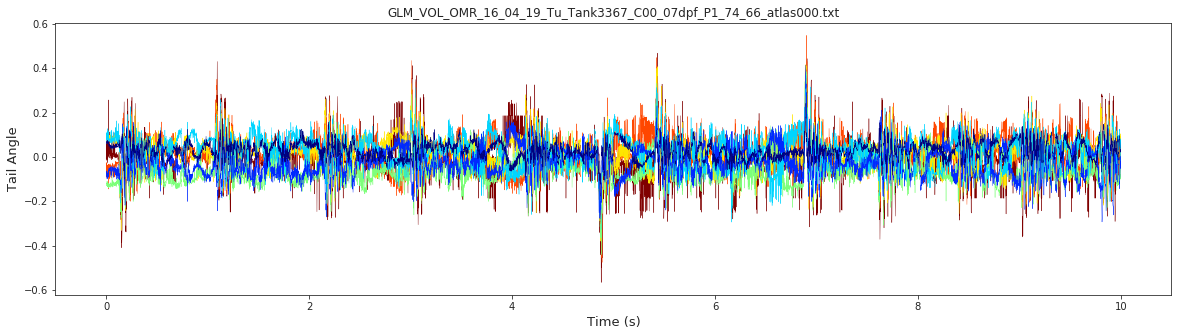

In [28]:
if PlotFlag:
    fig = plt.figure(figsize=(20,5))
    plt.title(ExperimentsList.iloc[i_fish]['fish_filename'])
    plt.xlabel('Time (s)', fontsize = 13)
    plt.ylabel('Tail Angle', fontsize = 13)
    for j in reversed(range(NumSegments)):
        plt.plot(t,tail_angle[IdSt:IdSt+Duration,j], color=colors[j],lw=.4)
    plt.show()

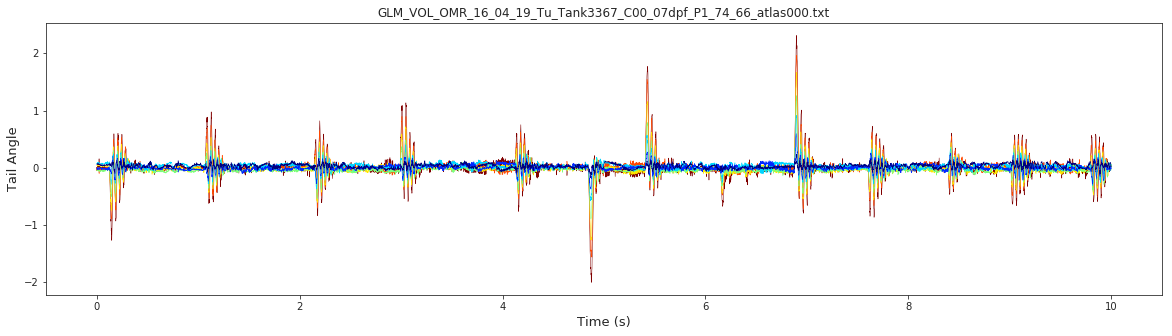

In [29]:
if PlotFlag:
    fig = plt.figure(figsize=(20,5))
    plt.title(ExperimentsList.iloc[i_fish]['fish_filename'])
    plt.xlabel('Time (s)', fontsize = 13)
    plt.ylabel('Tail Angle', fontsize = 13)
    for j in reversed(range(NumSegments)):
        plt.plot(t,bouts['cumul_tail_angle'][IdSt:IdSt+Duration,j], color=colors[j],lw=.5)
    plt.show()    

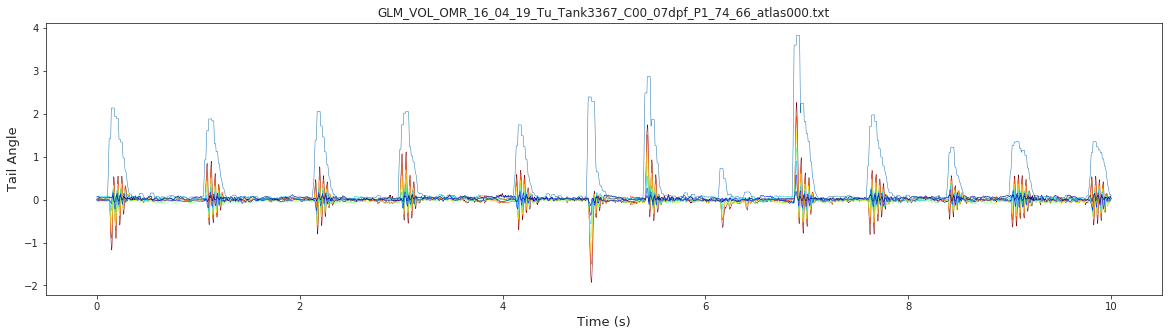

In [31]:
if PlotFlag:
    fig = plt.figure(figsize=(20,5))
    plt.title(ExperimentsList.iloc[i_fish]['fish_filename'])
    plt.xlabel('Time (s)', fontsize = 13)
    plt.ylabel('Tail Angle', fontsize = 13)
    for j in reversed(range(NumSegments)):
        plt.plot(t,bouts['smooth_cumul_tail_angle'][IdSt:IdSt+Duration,j], color=colors[j],lw=.5)    
    plt.plot(t,bouts['smoother_tail_curve_measure'][IdSt:IdSt+Duration],lw=.5)
    plt.show()

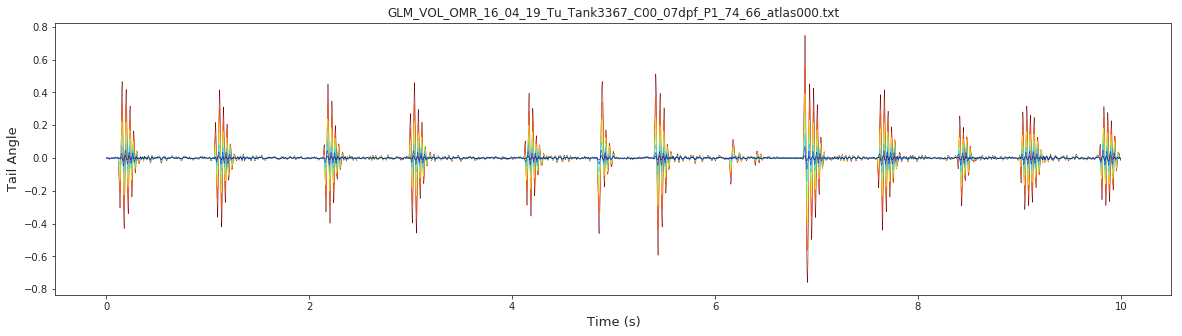

In [32]:
if PlotFlag:
    fig = plt.figure(figsize=(20,5))
    plt.title(ExperimentsList.iloc[i_fish]['fish_filename'])
    plt.xlabel('Time (s)', fontsize = 13)
    plt.ylabel('Tail Angle', fontsize = 13)
    for j in reversed(range(NumSegments)):
        plt.plot(t,bouts['cumul_filtered_segment_angles'][IdSt:IdSt+Duration,j], color=colors[j],lw=.5)
    plt.show()    

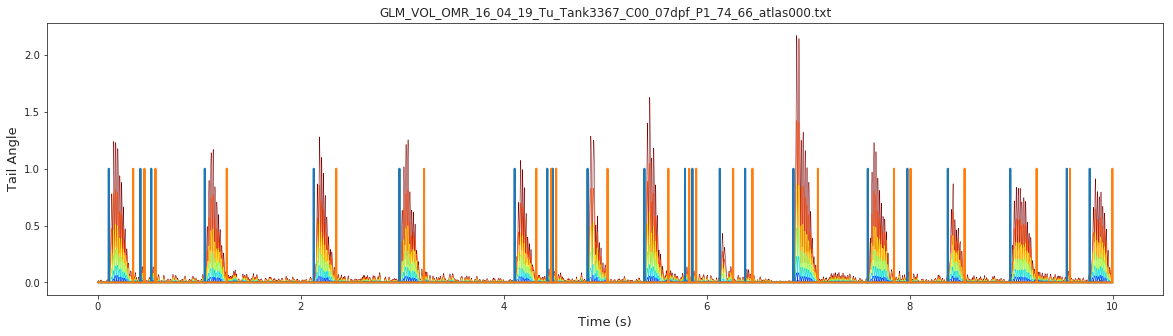

In [33]:
if PlotFlag:
    fig = plt.figure(figsize=(20,5))
    plt.title(ExperimentsList.iloc[i_fish]['fish_filename'])
    plt.xlabel('Time (s)', fontsize = 13)
    plt.ylabel('Tail Angle', fontsize = 13)
    for j in reversed(range(NumSegments)):
        plt.plot(t,bouts['super_cumul_filtered_segment_angles'][IdSt:IdSt+Duration,j], color=colors[j],lw=.5)

    plt.plot(t,bouts['all_bout_start'][IdSt:IdSt+Duration],lw=2)
    plt.plot(t,bouts['all_bout_end'][IdSt:IdSt+Duration],lw=2)
    plt.show()

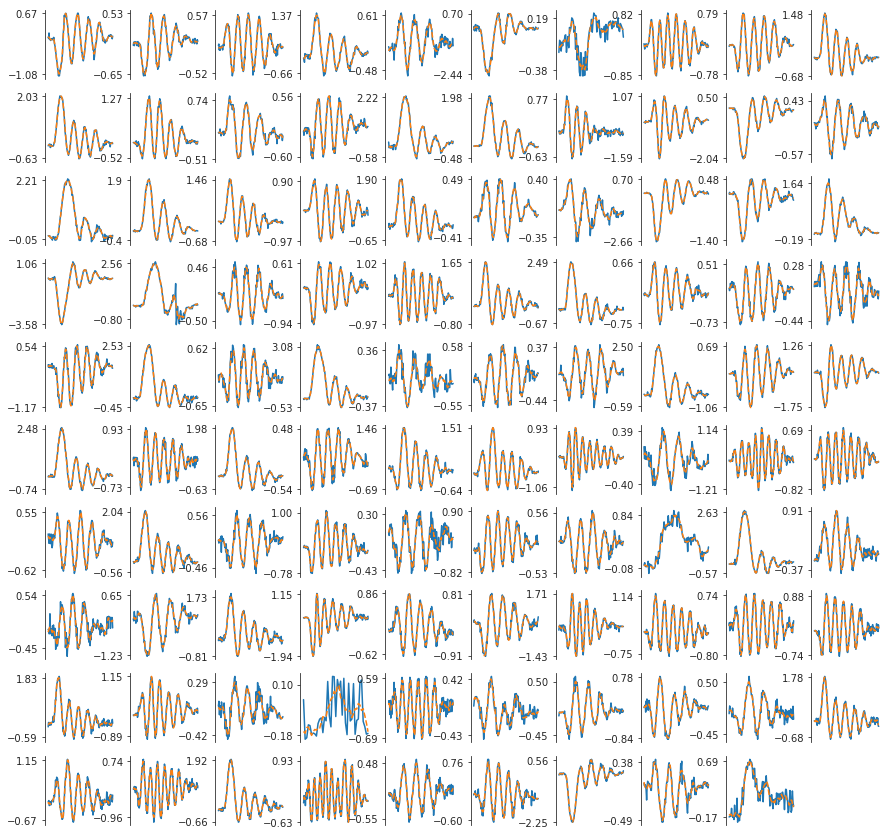

In [34]:
 if PlotFlag:
        
    import matplotlib.gridspec as gridspec
    gridnum=np.ceil(np.sqrt(bouts['good_bout_start_ind'].shape[0]))
    plt.figure(figsize=(15,15))

    if (gridnum<11):
        G = gridspec.GridSpec(gridnum,gridnum)
        for n in range(bouts['good_bout_start_ind'].shape[0]):
            [i,j]=np.unravel_index(n, (gridnum,gridnum))
            axis = plt.subplot(G[i,j])
            tmp1=bouts['cumul_tail_angle'][bouts['good_bout_start_ind'][i_val]:bouts['good_bout_end_ind'][i_val],7]
            axis.plot(tmp1)
            tmp2=bouts['smooth_cumul_tail_angle'][bouts['good_bout_start_ind'][i_val]:bouts['good_bout_end_ind'][i_val],7]
            axis.plot(tmp2,'--')
            #tmp3=bouts['smoother_tail_curve_measure'][bouts['good_bout_start_ind'][i_val]:bouts['good_bout_end_ind'][i_val]]
            #axis.plot(tmp3)
            axis.spines['right'].set_visible(False)
            axis.spines['top'].set_visible(False)
            axis.spines['bottom'].set_visible(False)
            axis.set_yticks([np.around(np.min(tmp2), decimals=2),np.around(np.max(tmp2), decimals=2)])
            axis.set_xticks([])

    else:
        gridnum=10
        G = gridspec.GridSpec(gridnum,gridnum)
        stepsize=np.floor(bouts['good_bout_start_ind'].shape[0]/100);
        count=1;
        for i, i_val in enumerate(np.arange(stepsize,stepsize*100,stepsize).astype(int)):
            [i,j]=np.unravel_index(i, (gridnum,gridnum))
            axis = plt.subplot(G[i,j])
            tmp1=bouts['cumul_tail_angle'][bouts['good_bout_start_ind'][i_val]:bouts['good_bout_end_ind'][i_val],7]
            axis.plot(tmp1)
            tmp2=bouts['smoother_tail_curve_measure'][bouts['good_bout_start_ind'][i_val]:bouts['good_bout_end_ind'][i_val]]
            tmp2=bouts['smooth_cumul_tail_angle'][bouts['good_bout_start_ind'][i_val]:bouts['good_bout_end_ind'][i_val],7]
            axis.plot(tmp2,'--')
            #tmp3=bouts['smoother_tail_curve_measure'][bouts['good_bout_start_ind'][i_val]:bouts['good_bout_end_ind'][i_val]]
            #axis.plot(tmp3)
            axis.spines['right'].set_visible(False)
            axis.spines['top'].set_visible(False)
            axis.spines['bottom'].set_visible(False)
            axis.set_yticks([np.around(np.min(tmp2), decimals=2),np.around(np.max(tmp2), decimals=2)])
            axis.set_xticks([])

    plt.show()      

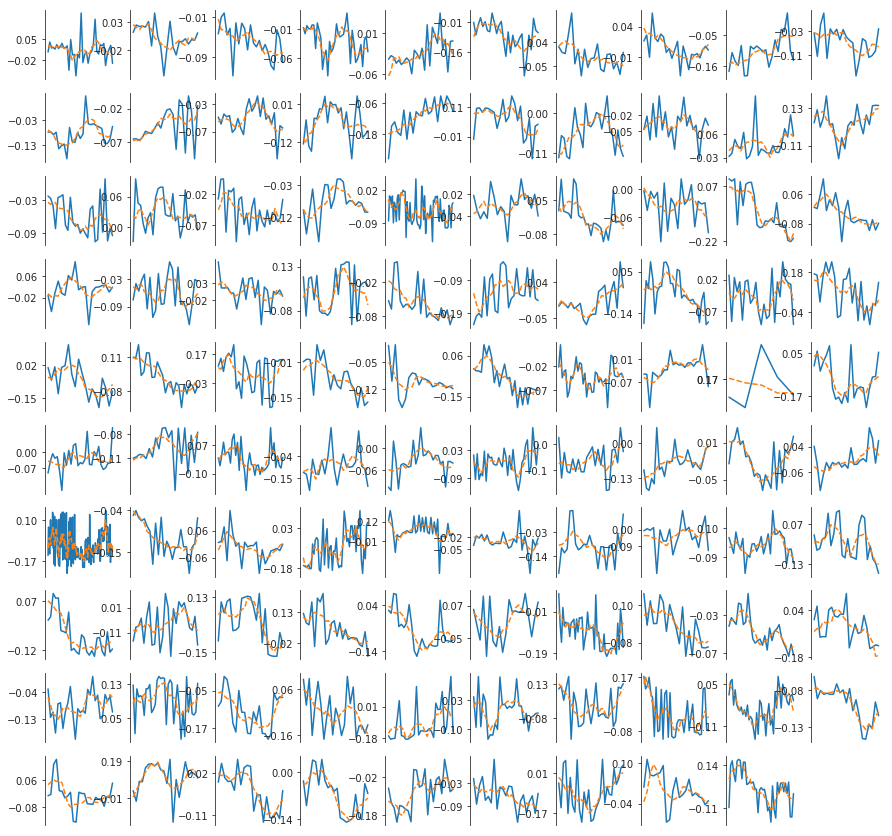

In [35]:
 if PlotFlag:
        
    import matplotlib.gridspec as gridspec
    gridnum=np.ceil(np.sqrt(bouts['bad_bout_start_ind'].shape[0]))
    plt.figure(figsize=(15,15))

    if (gridnum<11):
        G = gridspec.GridSpec(gridnum,gridnum)
        for n in range(bouts['bad_bout_start_ind'].shape[0]):
            [i,j]=np.unravel_index(n, (gridnum,gridnum))
            axis = plt.subplot(G[i,j])
            tmp1=bouts['cumul_tail_angle'][bouts['bad_bout_start_ind'][i_val]:bouts['bad_bout_end_ind'][i_val],7]
            axis.plot(tmp1)
            tmp2=bouts['smooth_cumul_tail_angle'][bouts['bad_bout_start_ind'][i_val]:bouts['bad_bout_end_ind'][i_val],7]
            axis.plot(tmp2,'--')
            #tmp3=bouts['smoother_tail_curve_measure'][bouts['good_bout_start_ind'][i_val]:bouts['good_bout_end_ind'][i_val]]
            #axis.plot(tmp3)
            axis.spines['right'].set_visible(False)
            axis.spines['top'].set_visible(False)
            axis.spines['bottom'].set_visible(False)
            axis.set_yticks([np.around(np.min(tmp2), decimals=2),np.around(np.max(tmp2), decimals=2)])
            axis.set_xticks([])

    else:
        gridnum=10
        G = gridspec.GridSpec(gridnum,gridnum)

        stepsize=np.floor(bouts['bad_bout_start_ind'].shape[0]/100);
        count=1;
        for i, i_val in enumerate(np.arange(stepsize,stepsize*100,stepsize).astype(int)):
            [i,j]=np.unravel_index(i, (gridnum,gridnum))
            axis = plt.subplot(G[i,j])
            tmp1=bouts['cumul_tail_angle'][bouts['bad_bout_start_ind'][i_val]:bouts['bad_bout_end_ind'][i_val],7]
            axis.plot(tmp1)
            tmp2=bouts['smooth_cumul_tail_angle'][bouts['bad_bout_start_ind'][i_val]:bouts['bad_bout_end_ind'][i_val],7]
            axis.plot(tmp2,'--')
            #tmp3=bouts['smoother_tail_curve_measure'][bouts['good_bout_start_ind'][i_val]:bouts['good_bout_end_ind'][i_val]]
            #axis.plot(tmp3)
            axis.spines['right'].set_visible(False)
            axis.spines['top'].set_visible(False)
            axis.spines['bottom'].set_visible(False)
            axis.set_yticks([np.around(np.min(tmp2), decimals=2),np.around(np.max(tmp2), decimals=2)])
            axis.set_xticks([])

    plt.show()      

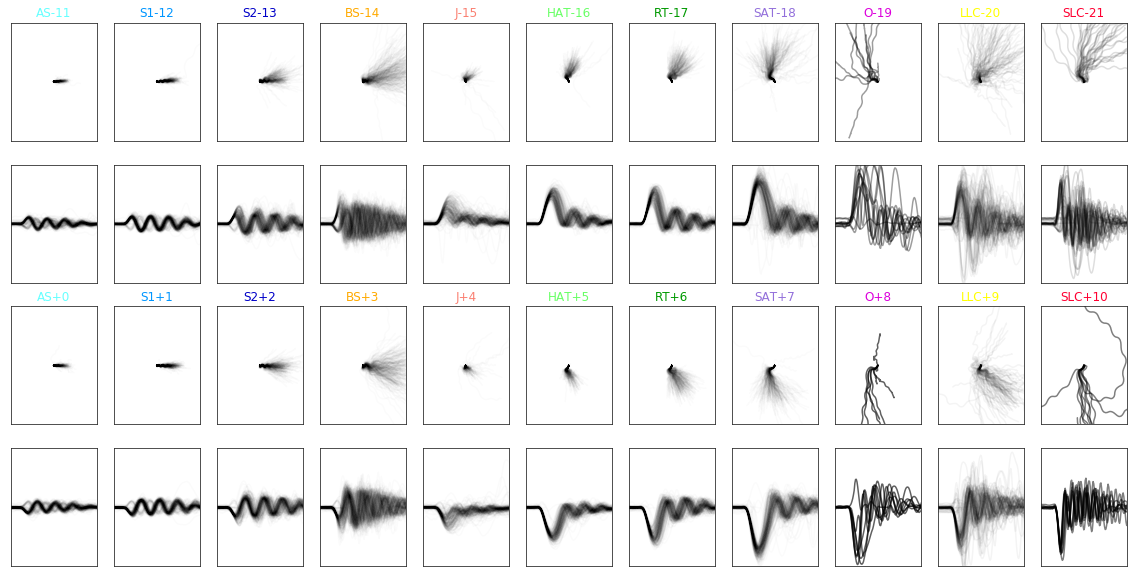

In [36]:
if PlotFlag:
    
    plt.figure(figsize=(20,10))
    import matplotlib.gridspec as gridspec
    from matplotlib import colors
    cmp = JoaoColormap()

    G = gridspec.GridSpec(4,11)
    ax0,ax1={},{}

    for b in range(0,22):


        l=(1 if b<11 else 0)
        b_sym=b%11#(b if b<13 else 26-b)#
        ax0 = plt.subplot(G[0+l*2,b_sym])
        ax1 = plt.subplot(G[1+l*2,b_sym])
    
        id=np.where(bouts['cat']==b)[0]    #id=np.argwhere(y_test[:,b+1]==1).flatten()

        if len(id)>0:
            id=id[0:min(300,len(id))]
            # Display Trajectory:
            xx=bouts['input_flat'][id,7*285:8*285]
            yy=bouts['input_flat'][id,8*285:9*285]
            ax0.plot(xx.T,yy.T,color='k',alpha=5/len(id))
            ax0.set_xlim(-7,7)
            ax0.set_ylim(-7,7)
            ax0.set_title(NameCatShort[b]+str(b), color=cmp(b_sym))
            ax0.set_xticks([])
            ax0.set_yticks([])
    
    
            # Display Tail Angle:
            tail_angle=bouts['input_flat'][id,0:7*285]
            tail_angle=tail_angle[:,0:1*285]+tail_angle[:,1*285:2*285]+tail_angle[:,2*285:3*285]+tail_angle[:,3*285:4*285]+tail_angle[:,4*285:5*285]+tail_angle[:,5*285:6*285]+tail_angle[:,6*285:7*285]
            ax1.plot(tail_angle.T,color='k',alpha=5/len(id))
            ax1.set_xlim(0,120)
            ax1.set_ylim(-3.5,3.5)
            ax1.set_xticks([])
            ax1.set_yticks([])
    
    #plt.savefig('ForwardBouts_Variability.png', bbox_inches='tight', dpi=200)                          
    plt.show()


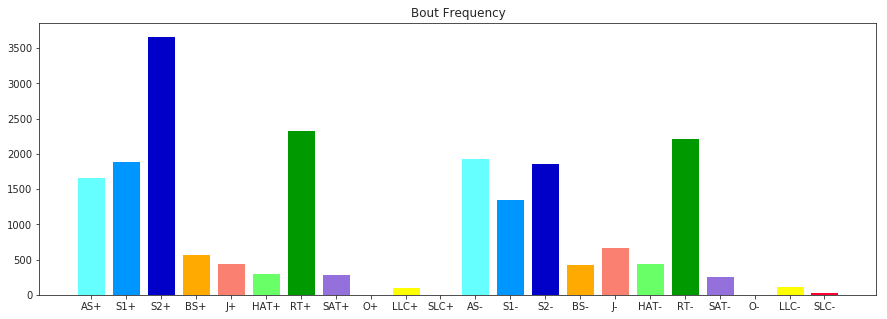

In [41]:
if PlotFlag:
    
    plt.figure(figsize=(15,5))
    plt.title('Bout Frequency')
    x=np.histogram(bouts['cat'],bins=np.arange(23))
    for b in range(22):
        b_sym=b_sym=b%11#(b if b<13 else 25-b)
        plt.bar(x[1][b],x[0][b],color=cmp(b_sym))
    plt.xticks(np.arange(22), NameCatShort.tolist())
    plt.show()

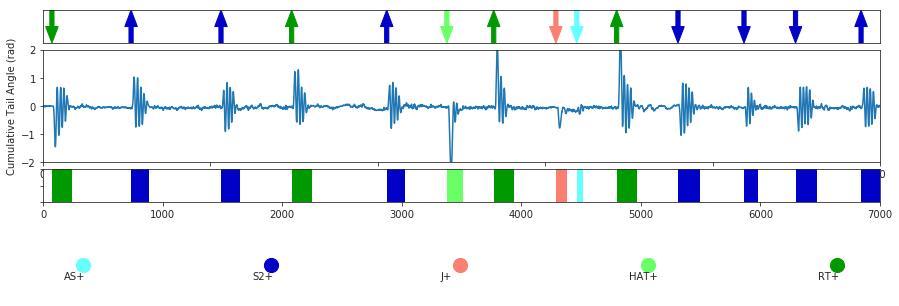

In [39]:
if PlotFlag:
    
    # Extract bout in the segment considered:
    tail_cat_tmp = bouts['tail_cat'][IdSt:IdSt+Duration].astype('int')
    
    tail_cat_sym_tmp = np.copy(tail_cat_tmp)#bouts['tail_cat_sym'][IdSt:IdSt+Duration].astype('int')
    tail_cat_sym_tmp[tail_cat_sym_tmp>-1] = tail_cat_sym_tmp[tail_cat_sym_tmp>-1]%11
    tail_st_tmp = bouts['tail_st'][IdSt:IdSt+Duration].astype('int')
    id_st_bout = np.argwhere(tail_st_tmp>0).flatten()

    cat_tmp = tail_cat_tmp[id_st_bout+1]
    cat_sym_tmp=np.array([b%11 for b in cat_tmp.tolist()])#np.array([b if b<13 else 25-b for b in cat_tmp.tolist()])


    plt.figure(figsize=(15,5))
    
    G = gridspec.GridSpec(7,1) 

    axis = plt.subplot(G[0])
    for i in range(len(id_st_bout)):
        if cat_tmp[i]>10:
            plt.arrow(t[id_st_bout[i]],0, 0, 1,length_includes_head=True,width=0.05,color=cmp(cat_sym_tmp[i]),head_length=0.5)
        else:
            plt.arrow(t[id_st_bout[i]],1, 0, -1,length_includes_head=True,width=0.05,color=cmp(cat_sym_tmp[i]),head_length=0.5)

    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlim(0,Duration/fps_original)

    axis = plt.subplot(G[1:4])
    axis.plot(t,bouts['smooth_cumul_tail_angle'][IdSt:IdSt+Duration,7])
    axis.set_ylabel('Cumulative Tail Angle (rad)')
    axis.set_ylim(-2,2)
    axis.set_xlim(0,Duration/fps_original)

    axis = plt.subplot(G[4])
    tmp=tail_cat_sym_tmp
    cmpW = JoaoColormap()
    cmpW.set_under(color='white')
    axis.imshow(tmp[:,np.newaxis].T,aspect='auto', cmap=cmpW,vmin=0,vmax=10)#,extent=[0,10,13,0])
    axis.set_yticklabels([])

    axis = plt.subplot(G[6])

    cat_sym_unique=np.unique(cat_sym_tmp)
    for i in range(len(cat_sym_unique)):
        tmp_str=NameCatShort[cat_sym_unique[i]]
        axis.scatter(i,0,color=cmp(cat_sym_unique[i]),s=200)
        axis.text(i-0.1,-0.2,tmp_str)
    axis.axis('off')
